In [1]:
import json
import os 
import re
import ast
import copy 
from datasets import load_dataset
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
# adgen 数据集

In [4]:
with open('AdvertiseGen/dev.json') as f:
    data = [json.loads(line) for line in f]

train_examples = [{
    "content": "你现在是一名销售员，根据以下商品标签生成一段有吸引力的商品广告词: " + x['content'],
    "summary": x['summary'],
} for x in data]


In [ ]:
os.makedirs("AdvertiseGen/formatted_data", exist_ok=True)

with open("AdvertiseGen/formatted_data/advertise_dev.json", "w") as f:
    for e in train_examples:
        f.write(json.dumps(e, ensure_ascii=False) + "\n")

In [5]:
with open('AdvertiseGen/dev.json', 'r') as f:
    data = [json.loads(line) for line in f]

In [6]:
data[0]

{'content': '类型#上衣*材质#牛仔布*颜色#白色*风格#简约*图案#刺绣*衣样式#外套*衣款式#破洞',
 'summary': '简约而不简单的牛仔外套，白色的衣身十分百搭。衣身多处有做旧破洞设计，打破单调乏味，增加一丝造型看点。衣身后背处有趣味刺绣装饰，丰富层次感，彰显别样时尚。'}

In [7]:
with open('AdvertiseGen/formatted_data/advertise_dev.json', 'r') as f:
    data = [json.loads(line) for line in f]

In [8]:
data[0]

{'content': '你现在是一名销售员，根据以下商品标签生成一段有吸引力的商品广告词: 类型#上衣*材质#牛仔布*颜色#白色*风格#简约*图案#刺绣*衣样式#外套*衣款式#破洞',
 'summary': '简约而不简单的牛仔外套，白色的衣身十分百搭。衣身多处有做旧破洞设计，打破单调乏味，增加一丝造型看点。衣身后背处有趣味刺绣装饰，丰富层次感，彰显别样时尚。'}

In [10]:
# glaive tool call 数据集

In [11]:
with open('glaive_toolcall_10k.json', 'r') as f:
    data = json.load(f)

In [12]:
data[0]

{'conversations': [{'from': 'human',
   'value': "I saw a dress that I liked. It was originally priced at $200 but it's on sale for 20% off. Can you tell me how much it will cost after the discount?"},
  {'from': 'function_call',
   'value': '{"name": "calculate_discount", "arguments": {"original_price": 200, "discount_percentage": 20}}'},
  {'from': 'observation', 'value': '{"discounted_price": 160}'},
  {'from': 'gpt',
   'value': 'The dress will cost you $160 after the 20% discount.'}],
 'tools': '[{"name": "calculate_discount", "description": "Calculate the discounted price", "parameters": {"type": "object", "properties": {"original_price": {"type": "number", "description": "The original price of the item"}, "discount_percentage": {"type": "number", "description": "The percentage of discount"}}, "required": ["original_price", "discount_percentage"]}}]'}

In [2]:
def convert_tools(input_string):
    # Split the input string into separate functions using the pattern
    pattern = r'(.*?):\s(.*?)\nParameters:\s(.*?)\nOutput:\s(.*?)\n\s-\sFormat:\s(.*?)\n\s-\sStructure:\s(.*?)\n'
    functions = re.findall(pattern, input_string, re.DOTALL)
    functions_list = []
    # Iterate over the functions and print them out
    for func in functions:
        tool = {}
        function_name, description, parameters, output, format_type, structure = func
        tool["name"] = function_name
        tool["description"] = description
        parameters_dict = json.loads(parameters)
        required_keys_list = []
        for key in parameters_dict.keys():
            value = parameters_dict[key]
            required_loc = value.find("Required.")
            if required_loc >= 0:
                required_keys_list.append(key)
                value = value[required_loc+9:].strip()
            key_type = value[:value.find('.')].strip()
            key_description = value[value.find('.')+1:].strip()
            new_value = {"type": key_type, "description": key_description}
            parameters_dict[key] = new_value
        tool["parameters"] = {"type": "object", "properties": parameters_dict, "required": required_keys_list}
        tool["output"] = output
        tool["format"] = format_type
        tool["structure"] = structure
        functions_list.append(tool)
    return json.dumps(functions_list)

In [3]:
def format_example(example, tools=None):
    new_example = {}
    if tools:
        new_example['tools'] = json.dumps(tools)
    else:
        new_example['tools'] = convert_tools(example['tools'][0])
    conversations = []
    if isinstance(example['conversations'], str):
        conversations_raw = json.loads(example['conversations'])
    else:
        conversations_raw = example['conversations']
    for item in conversations_raw:
        new_item = {}
        observation = None
        if item['role'] == 'user':
            new_item['from'] = 'human'
            new_item['value'] = item['content']
        elif item['role'] == 'assistant':
            new_item['from'] = 'gpt'
            new_item['value'] = item['content']
        elif item['role'] == 'tool':
            if conversations[-1]['from'] == 'gpt':
                conversations.pop()
            new_item['from'] = 'function_call'
            new_item['value'] = json.dumps({'name': item['name'], 'arguments': item['parameters']})
            if 'observation' in item:
                observation = {'from': 'observation', 'value': item['observation']}
        conversations.append(new_item)
        if observation is not None:
            conversations.append(observation)
    new_example['conversations'] = conversations
    return new_example

In [4]:
def format_example_dev(example, tools=None):
    new_example = {}
    if tools:
        new_example['tools'] = json.dumps(tools)
    else:
        new_example['tools'] = convert_tools(example['tools'][0])
    conversations = []
    if isinstance(example['conversations'], str):
        conversations_raw = json.loads(example['conversations'])
    else:
        conversations_raw = example['conversations']
    for item in conversations_raw:
        new_item = {}
        observation = None
        if item['role'] == 'user':
            new_item['from'] = 'human'
            new_item['value'] = item['content']
        elif item['role'] == 'assistant':
            new_item['from'] = 'gpt'
            new_item['value'] = item['content']
        elif item['role'] == 'tool':
            if conversations[-1]['from'] == 'gpt':
                conversations.pop()
            new_item['from'] = 'function_call'
            new_item['value'] = json.dumps({'name': item['name'], 'arguments': item['parameters']})
            if 'observation' in item:
                observation = {'from': 'observation', 'value': item['observation']}
        conversations.append(new_item)
        if observation is not None:
            conversations.append(observation)
    new_example['conversations'] = conversations[:2]
    return new_example

In [5]:
# roborock 数据集

In [6]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset.jsonl', "r", encoding="utf-8") as f:
    if 'robocontrol_dataset.jsonl'.endswith(".json"):
        train_data = json.load(f)
    elif 'robocontrol_dataset.jsonl'.endswith(".jsonl"):
        train_data = [json.loads(line) for line in f]

In [7]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_testset.jsonl', "r", encoding="utf-8") as f:
    if 'robocontrol_dataset_testset.jsonl'.endswith(".json"):
        dev_data = json.load(f)
    elif 'robocontrol_dataset_testset.jsonl'.endswith(".jsonl"):
        dev_data = [json.loads(line) for line in f]

In [8]:
tools = json.loads(train_data[0]['tools'])

In [9]:
for i in range(len(tools)):
    tool = tools[i]
    
    if (tool['parameters'] is None):
        tool['parameters'] = {'type': 'object', 'properties': {}}
    elif tool['parameters'].get('properties', None) is None:
        tool['parameters']['properties'] = {}
    parameters = list(tool['parameters']['properties'].keys())
    
    required = tool['parameters'].get('required', None)
    if required is None:
        required = tool.get('required', None)
        if required is None:
            tool['parameters']['required'] = []
        else:
            tool['parameters']['required'] = required
            
    for name in tool['parameters']['required']:
        if name not in parameters:
            print(i, tool)
            break

0 {'name': 'general_control', 'description': 'This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task', 'parameters': {'type': 'object', 'properties': {'action': {'type': 'string', 'enum': ['start', 'stop', 'pause', 'resume']}, 'user_defined_task': {'type': 'string', 'description': 'user-defined task described in user request'}}, 'required': ['operation_type']}}
11 {'name': 'mapping', 'description': 'api for building map', 'parameters': {'type': 'object', 'properties': {'action': {'type': 'string', 'enum': ['start', 'stop', 'pause', 'resume']}}, 'required': ['operation_type']}}


In [10]:
tool_name = "mapping"

In [11]:
keys_list = []
records = []
len_records = []
for i in range(len(train_data)):
    if json.loads(train_data[i]['conversations'])[1]["role"] == "tool":
        if json.loads(train_data[i]['conversations'])[1]['name'] == tool_name:
            parameters = json.loads(train_data[i]['conversations'])[1]['parameters']
            if parameters is None:
                keys = []
                keys_list += keys
            else:
                keys = list(parameters.keys())
                keys_list += keys
            records.append((i, len(keys)))
            len_records.append(len(keys))
    else:
        assert json.loads(train_data[i]['conversations'])[1]["role"] == "assistant"
print(set(keys_list))
print(set(len_records))

{'action'}
{1}


In [12]:
tool_name = "general_control"

In [13]:
keys_list = []
records = []
len_records = []
for i in range(len(train_data)):
    if json.loads(train_data[i]['conversations'])[1]["role"] == "tool":
        if json.loads(train_data[i]['conversations'])[1]['name'] == tool_name:
            parameters = json.loads(train_data[i]['conversations'])[1]['parameters']
            if parameters is None:
                keys = []
                keys_list += keys
            else:
                keys = list(parameters.keys())
                keys_list += keys
            records.append((i, len(keys)))
            len_records.append(len(keys))
    else:
        assert json.loads(train_data[i]['conversations'])[1]["role"] == "assistant"
print(set(keys_list))
print(set(len_records))

{'user_defined_task', 'action'}
{1, 2}


In [14]:
for i in records:
    if i[1] == 1:
        print(train_data[i[0]]['conversations'])

[{"role": "user", "content": "Timeout"}, {"role": "tool", "name": "general_control", "parameters": {"action": "pause"}}]
[{"role": "user", "content": "立即停止"}, {"role": "tool", "name": "general_control", "parameters": {"action": "stop"}}]
[{"role": "user", "content": "稍等"}, {"role": "tool", "name": "general_control", "parameters": {"action": "pause"}}]
[{"role": "user", "content": "给我开始"}, {"role": "tool", "name": "general_control", "parameters": {"action": "start"}}]
[{"role": "user", "content": "恢复动作"}, {"role": "tool", "name": "general_control", "parameters": {"action": "resume"}}]
[{"role": "user", "content": "启动任务"}, {"role": "tool", "name": "general_control", "parameters": {"action": "start"}}]
[{"role": "user", "content": "Freeze"}, {"role": "tool", "name": "general_control", "parameters": {"action": "pause"}}]
[{"role": "user", "content": "中断任务"}, {"role": "tool", "name": "general_control", "parameters": {"action": "pause"}}]
[{"role": "user", "content": "继续前进"}, {"role": "tool"

In [15]:
tools[0]['parameters']['required'] = ['action']
tools[11]['parameters']['required'] = ['action']

In [16]:
for i in range(len(tools)):
    tool = tools[i]
    assert 'properties' in tool['parameters']
    assert isinstance(tool['parameters']['properties'], dict)
    assert 'required' in tool['parameters']
    assert isinstance(tool['parameters']['required'], list)

In [17]:
train_data_new = []
for i in range(len(train_data)):
    try:
        train_data_new.append(format_example(train_data[i], tools))
    except:
        # print(i)
        pass

In [18]:
len(train_data_new)

3232

In [19]:
dev_data_new = []
for i in range(len(dev_data)):
    try:
        dev_data_new.append(format_example_dev(dev_data[i], tools))
    except:
        # print(i)
        pass

In [20]:
len(dev_data_new)

1078

In [22]:
dev_data_new[0]

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [24]:
for i in range(len(train_data)):
    if train_data[i]['num_decomposition'] > 1:
        print(i)

299
376


In [33]:
train_data_new[299]

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [34]:
train_data[299]

{'user_request': '查看前五条和后五条预约任务',
 'task_decomposition': '[{"name": "schedule_operation", "parameters": {"operation_type": "query", "index_from": 1, "index_to": 5}}, {"name": "schedule_operation", "parameters": {"operation_type": "query", "index_from": -5, "index_to": -1}}]',
 'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["operation_type"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action

In [386]:
for i in range(len(train_data)):
    if train_data[i]['hit'] == False:
        print(i)

71
110
229
266
308
331
351
412
433
446
670
700
871
990
997
1006
1094
1100
1103
1179
1243
1452
1456
1527
1540
1592
1593
1799
1883
1895
1947
2024
2225
2257
2306
2475
2537
2657
2698
2715
2721
2779
2853
2955
3080
3163
3201


In [389]:
train_data[3201]

{'user_request': 'user_defined_task:[Open Area Polish|Basement De-clutter]$$Switch on Attic Arrangement',
 'task_decomposition': '"<null>"',
 'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["operation_type"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the descript

In [388]:
train_data_new[3201]

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [384]:
train_data_new[0]

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [25]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_sharegpt.json', 'w') as file:
    data = json.dump(train_data_new, file)
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_sharegpt.json', 'r') as f:
    data = json.load(f)
for i in range(len(data)):
    assert data[i] == train_data_new[i]

In [26]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_testset_sharegpt.json', 'w') as file:
    data = json.dump(dev_data_new, file)
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_testset_sharegpt.json', 'r') as f:
    data = json.load(f)
for i in range(len(data)):
    assert data[i] == dev_data_new[i]

In [27]:
# result analysis 

In [123]:
# sft 

In [36]:
with open('../roborock_control_lora/checkpoint-1000/trainer_state.json', 'r') as f:
    train_state = json.load(f)

In [37]:
log_history = train_state['log_history']
steps = [i['step'] for i in log_history]
learning_rate = [i['learning_rate'] for i in log_history]
loss = [i['loss'] for i in log_history]

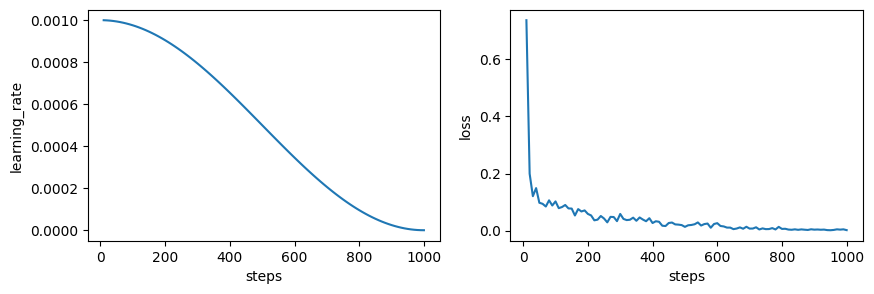

In [38]:
# Create a figure and two subplots, sharing the same y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot data on each axis
ax1.plot(steps, learning_rate)
ax2.plot(steps, loss)

# Optionally, set titles for each subplot
ax1.set_xlabel('steps')
ax1.set_ylabel('learning_rate')
ax2.set_xlabel('steps')
ax2.set_ylabel('loss')

# Show the figure
plt.show()


In [122]:
# dpo 

In [112]:
with open('../models/roborock_control_lora_dpo/checkpoint-20/trainer_state.json', 'r') as f:
    train_state = json.load(f)

In [114]:
log_history = train_state['log_history']
steps = [i['step'] for i in log_history]
learning_rate = [i['learning_rate'] for i in log_history]
loss = [i['loss'] for i in log_history]
logits_chosen = [i['logits/chosen'] for i in log_history]
logits_rejected = [i['logits/rejected'] for i in log_history]
rewards_chosen = [i['rewards/chosen'] for i in log_history]
rewards_rejected = [i['rewards/rejected'] for i in log_history]
rewards_accuracies = [i['rewards/accuracies'] for i in log_history]
rewards_margins = [i['rewards/margins'] for i in log_history]

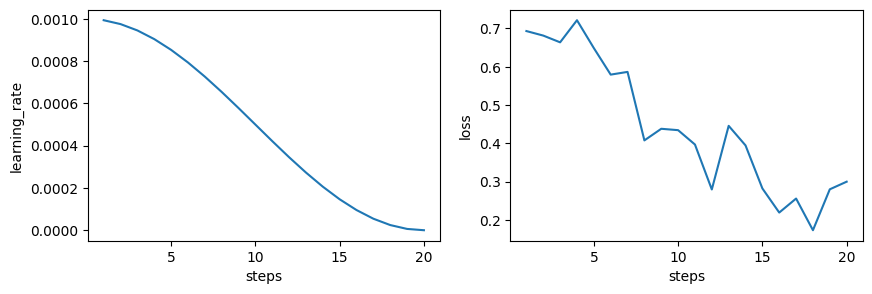

In [115]:
# Create a figure and two subplots, sharing the same y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot data on each axis
ax1.plot(steps, learning_rate)
ax2.plot(steps, loss)

# Optionally, set titles for each subplot
ax1.set_xlabel('steps')
ax1.set_ylabel('learning_rate')
ax2.set_xlabel('steps')
ax2.set_ylabel('loss')

# Show the figure
plt.show()

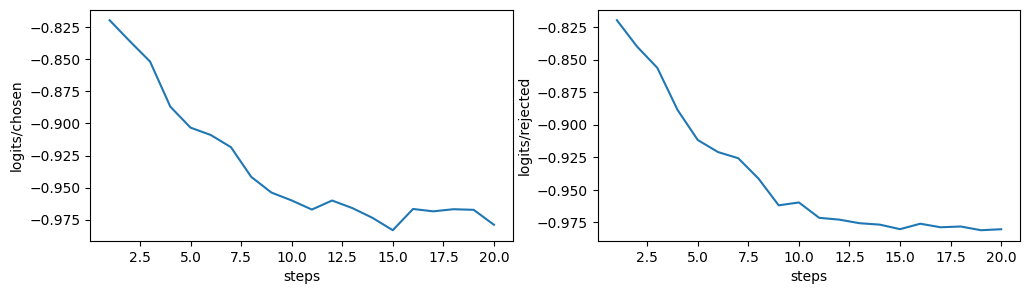

In [117]:
# Create a figure and two subplots, sharing the same y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot data on each axis
ax1.plot(steps, logits_chosen)
ax2.plot(steps, logits_rejected)

# Optionally, set titles for each subplot
ax1.set_xlabel('steps')
ax1.set_ylabel('logits/chosen')
ax2.set_xlabel('steps')
ax2.set_ylabel('logits/rejected')

# Show the figure
plt.show()

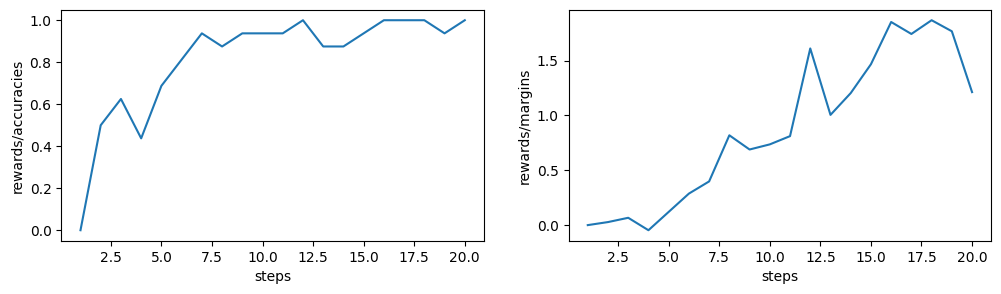

In [119]:
# Create a figure and two subplots, sharing the same y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot data on each axis
ax1.plot(steps, rewards_accuracies)
ax2.plot(steps, rewards_margins)

# Optionally, set titles for each subplot
ax1.set_xlabel('steps')
ax1.set_ylabel('rewards/accuracies')
ax2.set_xlabel('steps')
ax2.set_ylabel('rewards/margins')

# Show the figure
plt.show()

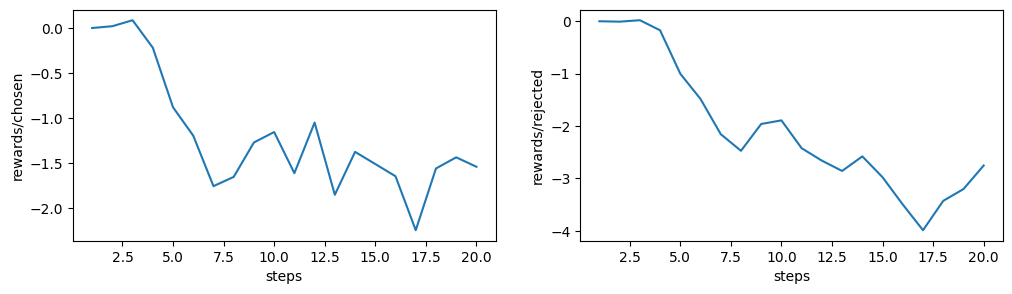

In [118]:
# Create a figure and two subplots, sharing the same y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot data on each axis
ax1.plot(steps, rewards_chosen)
ax2.plot(steps, rewards_rejected)

# Optionally, set titles for each subplot
ax1.set_xlabel('steps')
ax1.set_ylabel('rewards/chosen')
ax2.set_xlabel('steps')
ax2.set_ylabel('rewards/rejected')

# Show the figure
plt.show()

In [106]:
with open('../outputs/roborock_control_lora_output_testset_100/generated_predictions.jsonl', 'r') as f:
    generated_results = [json.loads(line) for line in f]

In [ ]:
with open('../outputs/roborock_control_lora_output_finetune_train/generated_predictions.jsonl', 'r') as f:
    train_generated_results = [json.loads(line) for line in f]

In [96]:
with open('../outputs/roborock_control_lora_dpo_output/generated_predictions.jsonl', 'r') as f:
    dpo_generated_results = [json.loads(line) for line in f]

In [84]:
def parse_tool_call(input_string):
    # 正则表达式匹配括号内的内容
    args_match = re.search(r".*tool_call\((.*)\).*", input_string)
    if not args_match:
        return "No arguments found."

    # 获取括号内的所有参数字符串
    args_string = args_match.group(1)

    # 使用堆栈来处理嵌套结构
    args_list = []
    stack = []
    last_index = 0
    for i, char in enumerate(args_string):
        if char == '{':
            stack.append(char)
        elif char == '}':
            stack.pop()
        elif char == ',' and not stack:
            # 当遇到逗号且堆栈为空时，表示这是一个顶级参数的分隔符
            args_list.append(args_string[last_index:i])
            last_index = i + 2  # 跳过逗号和空格

    # 添加最后一个参数到列表中
    args_list.append(args_string[last_index:])

    # 解析每个参数为键值对，并存储在字典中
    args_dict = {}
    try:
        for arg in args_list:
            key, value = arg.split('=', 1)
            args_dict[key.strip()] = ast.literal_eval(value.strip())
    except:
        pass

    return args_dict

In [85]:
def parse_action_input(input_string):
    # 使用正则表达式提取 Action 和 Action Input
    action_match = re.search(r'Action: (\w+)', input_string)
    action_input_match = re.search(r'Action Input:.*(\{.*\})', input_string)
    
    # 检查是否找到匹配项并提取
    action = action_match.group(1) if action_match else None
    action_input = json.loads(action_input_match.group(1)) if action_input_match else None
    return action, action_input

In [86]:
def format_prediction(input_string):
    input_string = input_string.strip()
    split = input_string.find('\n')
    if split >= 0:
        intent = input_string[:split].strip()
        method_string = input_string[split+1:].strip()
        if method_string.find('tool_call') >= 0:
            slot = parse_tool_call(method_string)
        elif (method_string.find('Action') >= 0) and (method_string.find('Action Input') >= 0):
            intent, slot = parse_action_input(method_string)
        else:
            slot = json.loads(input_string[split+1:].strip())
    else:
        intent = ''
        slot = {}
    return intent, slot

def cal_metric(label, prediction):
    target_intent, target_method = format_prediction(label)
    prediction_intent, prediction_method = format_prediction(prediction)
    if prediction_intent == target_intent:
        if prediction_method == target_method:
            result = [1, 1]
        else:
            result = [1, 0]
    else:
        result = [0, 0]
    return result 

In [87]:
def cal_lora(generated_results, model_name, set_name):
    print(model_name, set_name)
    results = []
    for i in range(len(generated_results)):
        label = generated_results[i]['label']
        prediction =  generated_results[i]['predict']
        try:
            result = cal_metric(label, prediction)
        except:
            print('oops', i)
        result += [dev_data_new[i]['conversations'][0]['value'], label, prediction]
        results.append(result)
    results = pd.DataFrame(results)
    results.columns = ['intent', 'slot', 'query', 'target', 'prediction']
    results['model_name'] = model_name
    results['set_name'] = set_name
    results = results.reset_index()
    return results 

In [88]:
def cal_accuracy(results):
    num = results.shape[0]
    intent = results['intent']
    zero_error_count = intent.shape[0]
    zero_error_rate = 1
    intent_sum, intent_mean = intent.sum(), intent.mean()
    slot = results[(results['intent'] == 1)]['slot']
    slot_sum, slot_mean = slot.sum(), slot.mean()
    both_mean = slot_sum / zero_error_count
    return pd.Series([num, zero_error_count, zero_error_rate, intent_sum, intent_mean, slot_sum, slot_mean, both_mean],
                     index=['num', 'zero_error_count', 'zero_error_rate', 'intent_sum', 'intent_mean', 'slot_sum', 'slot_mean', 'both_mean'])

In [28]:
# 做dpo数据集

In [29]:
with open('../outputs/roborock_control_lora_output_testset/generated_predictions.jsonl', 'r') as f:
    generated_results_testset = [json.loads(line) for line in f]

In [30]:
results = cal_lora(generated_results_testset, 'lora', 'test')

lora test


In [31]:
results 

,index,intent,slot,query,target,prediction,model_name,set_name
0,0,1,1,重新启动绘图程序。,"mapping\n{""action"": ""start""}","mapping\n{""action"": ""start""}",lora,test
1,1,1,1,开启建图模式。,"mapping\n{""action"": ""start""}","mapping\n{""action"": ""start""}",lora,test
2,2,1,0,检查所有刷子,"get_property\n{""property_name"": ""all consumabl...","get_property\n{""property_name"": ""main brush""}",lora,test
3,3,1,1,Activate follow mode,"follow_me\n{""action"": ""start""}","follow_me\n{""action"": ""start""}",lora,test
4,4,1,1,预约下周三早上清扫洗衣房下的洗衣机,"schedule_operation\n{""operation_type"": ""create...","schedule_operation\n{""operation_type"": ""create...",lora,test
...,...,...,...,...,...,...,...,...
1073,1073,1,1,"Resume the mopping session, please.","clean\n{""action"": ""resume"", ""tool"": ""mop only/...","clean\n{""action"": ""resume"", ""tool"": ""mop only/...",lora,test
1074,1074,1,1,Is the filter clean,"get_property\n{""property_name"": ""filter""}","get_property\n{""property_name"": ""filter""}",lora,test
1075,1075,1,1,主刷状态,"get_property\n{""property_name"": ""main brush""}","get_property\n{""property_name"": ""main brush""}",lora,test
1076,1076,1,1,当前声音等级是多少,"get_property\n{""property_name"": ""volume/音量""}","get_property\n{""property_name"": ""volume/音量""}",lora,test


In [32]:
results.groupby(['model_name', 'set_name']).apply(cal_accuracy)

,,num,zero_error_count,zero_error_rate,intent_sum,intent_mean,slot_sum,slot_mean,both_mean
model_name,set_name,,,,,,,,
lora,test,1078.0,1078.0,1.0,1044.0,0.96846,940.0,0.900383,0.871985


In [33]:
negative_samples = [i for i in range(len(dev_data)) if dev_data[i]['hit']==False]
results = results.set_index('index')
results['hit'] = True
results.loc[negative_samples, 'hit'] = False
results = results.reset_index()

In [34]:
# should not hit but hit something, intent肯定是0
shouldnot_hit_but_hit = results[(results['hit']==False)&(results['intent']==0)]['index'].tolist()

In [35]:
# should hit but not hit， intent肯定是0 
should_hit_but_not_hit = results[(results['prediction']=='\n no corresponding tools.')&(results['target']!='\n no corresponding tools.')]['index'].tolist()

In [36]:
# intent_1_slot_0
intent_1_slot_0 = results[(results['intent']==1)&(results['slot']==0)]['index'].tolist()

In [37]:
hard_examples = shouldnot_hit_but_hit + should_hit_but_not_hit + intent_1_slot_0

In [38]:
results['hard_examples'] = False
results['hard_type'] = None
results = results.set_index('index')
results.loc[hard_examples, 'hard_examples'] = True
results.loc[shouldnot_hit_but_hit, 'hard_type'] = 'should_not_hit_but_hit'
results.loc[should_hit_but_not_hit, 'hard_type'] = 'should_hit_but_not_hit'
results.loc[intent_1_slot_0, 'hard_type'] = 'intent_1_slot_0'
results = results.reset_index()

In [39]:
results.groupby(['hard_examples', 'intent', 'slot'])['hard_type'].value_counts()

hard_examples  intent  slot  hard_type             
True           0       0     should_not_hit_but_hit      9
                             should_hit_but_not_hit      4
               1       0     intent_1_slot_0           104
Name: count, dtype: int64

In [40]:
dev_data_dpo = [(i, results.loc[results['index']==i, 'target'].iloc[0], results.loc[results['index']==i, 'prediction'].iloc[0]) for i in results[(results['hard_examples']==True)&(results['index']>=100)]['index'].tolist()]

In [41]:
dev_data_dpo_new = []
for i in range(len(dev_data_dpo)):
    index = dev_data_dpo[i][0]
    new = {}
    conversations = copy.deepcopy(dev_data_new[index]['conversations'])
    response = conversations[1]
    if dev_data_dpo[i][1].find('no corresponding tools') >= 0:
        accept_response = {"from": "gpt", "value": dev_data_dpo[i][1].strip(' \n')}
    else:
        tool_name, arguments = dev_data_dpo[i][1].split("\n")
        accept_response = {"from": "function_call", "value": json.dumps({"name": tool_name, "arguments": json.loads(arguments)})}
    assert response == accept_response
    if dev_data_dpo[i][2].find('no corresponding tools') >= 0:
        reject_response = {"from": "gpt", "value": dev_data_dpo[i][2].strip(' \n')}
    else:
        tool_name, arguments = dev_data_dpo[i][2].split("\n")
        reject_response = {"from": "function_call", "value": json.dumps({"name": tool_name, "arguments": json.loads(arguments)})}
    conversations[1] = {"from": "gpt", "value": json.dumps([accept_response, reject_response])}
    new['tools'] = dev_data_new[index]['tools']
    new['conversations'] = conversations
    dev_data_dpo_new.append(new)

In [42]:
dev_data_dpo_new[2] 

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [43]:
dev_data_new[0] 

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [44]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_testset_dpo.json', 'w') as file:
    data = json.dump(dev_data_dpo_new, file)
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_testset_dpo.json', 'r') as f:
    data = json.load(f)
for i in range(len(data)):
    assert data[i] == dev_data_dpo_new[i]

In [45]:
a = load_dataset(path='json', data_files='ToolAlpaca/data/formatted_data/robocontrol_dataset_testset_dpo.json')

Generating train split: 0 examples [00:00, ? examples/s]

In [46]:
json.loads(a['train'][0]['conversations'][1]['value'])

[{'from': 'function_call',
  'value': '{"name": "general_control", "arguments": {"action": "resume"}}'},
 {'from': 'function_call',
  'value': '{"name": "general_control", "arguments": {"action": "start"}}'}]

In [47]:
# 真正的分析

In [124]:
# dpo 

In [120]:
results = cal_lora(dpo_generated_results, '3dpo', '2test')

3dpo 2test


In [121]:
results.groupby(['model_name', 'set_name']).apply(cal_accuracy)

,,num,zero_error_count,zero_error_rate,intent_sum,intent_mean,slot_sum,slot_mean,both_mean
model_name,set_name,,,,,,,,
3dpo,2test,100.0,100.0,1.0,94.0,0.94,72.0,0.765957,0.72


In [105]:
negative_samples = [i for i in range(len(dev_data)) if ((dev_data[i]['hit']==False) and (i < 100))]
results = results.set_index('index')
results['hit'] = True
results.loc[negative_samples, 'hit'] = False
results = results.reset_index()
shouldnot_hit_but_hit = results[(results['hit']==False)&(results['intent']==0)]['index'].tolist()
should_hit_but_not_hit = results[(results['prediction']=='\n no corresponding tools.')&(results['target']!='\n no corresponding tools.')]['index'].tolist()
intent_1_slot_0 = results[(results['intent']==1)&(results['slot']==0)]['index'].tolist()
hard_examples = shouldnot_hit_but_hit + should_hit_but_not_hit + intent_1_slot_0
results['hard_examples'] = False
results['hard_type'] = None
results = results.set_index('index')
results.loc[hard_examples, 'hard_examples'] = True
results.loc[shouldnot_hit_but_hit, 'hard_type'] = 'should_not_hit_but_hit'
results.loc[should_hit_but_not_hit, 'hard_type'] = 'should_hit_but_not_hit'
results.loc[intent_1_slot_0, 'hard_type'] = 'intent_1_slot_0'
results = results.reset_index()
results.groupby(['hard_examples', 'intent', 'slot'])['hard_type'].value_counts()

hard_examples  intent  slot  hard_type             
True           0       0     should_hit_but_not_hit     2
                             should_not_hit_but_hit     1
               1       0     intent_1_slot_0           22
Name: count, dtype: int64

In [107]:
final = results
for i in [i for i in range(len(dev_data)) if dev_data[i]['hit']==False]:
    if i < 100:
        print('index:', final[(final['model_name']=='1finetune') & (final['index']==i)].iloc[0]['index'])
        print('query:', final[(final['model_name']=='1finetune') & (final['index']==i)].iloc[0]['query'])
        print('target:', final[(final['model_name']=='1finetune') & (final['index']==i)].iloc[0]['target'])
        print('prediction:', final[(final['model_name']=='1finetune') & (final['index']==i)].iloc[0]['prediction'])

index: 10
query: user_defined_task:[Morning Routine|Evening Wind Down]$$Begin Nighttime Ritual
target: 
 no corresponding tools.
prediction: 
 no corresponding tools.
index: 47
query: user_defined_task:[例行巡查|紧急响应]$$实施安静模式
target: 
 no corresponding tools.
prediction: general_control
{"action": "start", "user_defined_task": "紧急响应"}


In [108]:
for i in range(final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].shape[0]):
    print('index:', final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].iloc[i]['index'])
    print('query:', final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].iloc[i]['query'])
    print('target:', final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].iloc[i]['target'])
    print('prediction:', final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].iloc[i]['prediction'])

index: 2
query: 检查所有刷子
target: get_property
{"property_name": "all consumables"}
prediction: get_property
{"property_name": "main brush"}
index: 4
query: 预约下周三早上清扫洗衣房下的洗衣机
target: schedule_operation
{"operation_type": "create", "action": "start", "tool": "vacuum and mop", "total_count": 1, "location": "洗衣房下的洗衣机", "time": "下周三早上"}
prediction: schedule_operation
{"operation_type": "create", "location": "洗衣房下的洗衣机"}
index: 7
query: Remove next cleaning task for the home office
target: schedule_operation
{"operation_type": "delete", "location": "home office", "relative": "next"}
prediction: schedule_operation
{"operation_type": "delete", "location": "home office"}
index: 13
query: Check scheduled cleaning for the hobby room next week.
target: schedule_operation
{"operation_type": "query", "location": "hobby room", "time": "next week"}
prediction: schedule_operation
{"operation_type": "query", "location": "hobby room next week"}
index: 17
query: Lock onto the standard cleaning mode for every

In [125]:
# sft 

In [23]:
results = []
results.append(cal_lora(generated_results, '1finetune', '2test'))
# results.append(cal_lora(train_generated_results, '1finetue', '1train'))
results = pd.concat(results, axis=0)
results = results.reset_index(drop=True)

1finetune 2test


In [37]:
results.groupby(['model_name', 'set_name']).apply(cal_accuracy)

,,num,zero_error_count,zero_error_rate,intent_sum,intent_mean,slot_sum,slot_mean,both_mean
model_name,set_name,,,,,,,,
1finetue,1train,100.0,100.0,1.0,99.0,0.99,98.0,0.989899,0.98
1finetune,2test,100.0,100.0,1.0,97.0,0.97,86.0,0.886598,0.86


In [111]:
negative_samples = [i for i in range(len(dev_data)) if ((dev_data[i]['hit']==False) and (i < 100))]
results = results.set_index('index')
results['hit'] = True
results.loc[negative_samples, 'hit'] = False
results = results.reset_index()
shouldnot_hit_but_hit = results[(results['hit']==False)&(results['intent']==0)]['index'].tolist()
should_hit_but_not_hit = results[(results['prediction']=='\n no corresponding tools.')&(results['target']!='\n no corresponding tools.')]['index'].tolist()
intent_1_slot_0 = results[(results['intent']==1)&(results['slot']==0)]['index'].tolist()
hard_examples = shouldnot_hit_but_hit + should_hit_but_not_hit + intent_1_slot_0
results['hard_examples'] = False
results['hard_type'] = None
results = results.set_index('index')
results.loc[hard_examples, 'hard_examples'] = True
results.loc[shouldnot_hit_but_hit, 'hard_type'] = 'should_not_hit_but_hit'
results.loc[should_hit_but_not_hit, 'hard_type'] = 'should_hit_but_not_hit'
results.loc[intent_1_slot_0, 'hard_type'] = 'intent_1_slot_0'
results = results.reset_index()
results.groupby(['hard_examples', 'intent', 'slot'])['hard_type'].value_counts()

hard_examples  intent  slot  hard_type             
True           0       0     should_not_hit_but_hit     1
               1       0     intent_1_slot_0           11
Name: count, dtype: int64

In [46]:
final = results
for i in [i for i in range(len(dev_data)) if dev_data[i]['hit']==False]:
    if i < 100:
        print('index:', final[(final['model_name']=='1finetune') & (final['index']==i)].iloc[0]['index'])
        print('query:', final[(final['model_name']=='1finetune') & (final['index']==i)].iloc[0]['query'])
        print('target:', final[(final['model_name']=='1finetune') & (final['index']==i)].iloc[0]['target'])
        print('prediction:', final[(final['model_name']=='1finetune') & (final['index']==i)].iloc[0]['prediction'])

index: 10
query: user_defined_task:[Morning Routine|Evening Wind Down]$$Begin Nighttime Ritual
target: 
no corresponding tools.
prediction: 
no corresponding tools.
index: 47
query: user_defined_task:[例行巡查|紧急响应]$$实施安静模式
target: 
no corresponding tools.
prediction: set_object_property
{"property_name": "suction power", "property_value": "Quiet/安静/lowest"}


In [38]:
for i in range(final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].shape[0]):
    print('index:', final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].iloc[i]['index'])
    print('query:', final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].iloc[i]['query'])
    print('target:', final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].iloc[i]['target'])
    print('prediction:', final[(final['model_name']=='1finetune') & ((final['intent']==1) & (final['slot']==0))].iloc[i]['prediction'])

index: 2
query: 检查所有刷子
target: get_property
{"property_name": "all consumables"}
prediction: get_property
{"property_name": "main brush"}
index: 7
query: Remove next cleaning task for the home office
target: schedule_operation
{"operation_type": "delete", "location": "home office", "relative": "next"}
prediction: schedule_operation
{"operation_type": "delete", "location": "home office", "index_from": 1, "index_to": 1}
index: 8
query: See recent cleaning history for the bathroom
target: schedule_operation
{"operation_type": "query", "location": "bathroom"}
prediction: schedule_operation
{"operation_type": "query", "location": "bathroom", "relative": "previous"}
index: 21
query: 阳台的左侧和右侧各扫一次。
target: clean
{"action": "start", "location": "阳台的右侧", "tool": "vacuum only/扫"}
prediction: clean
{"action": "start", "location": "阳台的左侧和右侧", "tool": "vacuum only/扫"}
index: 29
query: Heighten the water output for a deeper mop cleanse.
target: set_object_property
{"property_name": "water flow and sc

In [76]:
[tool for tool in tools if tool['name'] == 'clean']

[{'name': 'clean',
  'description': 'Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.',
  'parameters': {'type': 'object',
   'properties': {'action': {'type': 'string',
     'enum': ['start', 'stop', 'pause', 'resume']},
    'location': {'type': 'string',
     'description': "Fill in the description of the location from the user request word for word, using the same language as in the user's description of the location."},
    'tool': {'type': 'string',
     'enum': ['vacuum only/扫', 'mop only/拖/擦', 'vacuum and mop'],
     'default': 'vacuum and mop',
     'description': "'vacuum and mop' means vacuum and mop the floor at the same time, 'vacuum only' is only vacuum, in Chinese, '扫' is 'vacuum only', '清扫' is 'vacuum and mop'"},
    'total_count': {'type': 'number',
     'default': 1,
     'description': 'The total count of the operation that is repeated within a single action.'},
    'special_mode': {'